In [1]:
!pip install biopython
!pip install dmslogo
!pip install wiggelen

from google.colab import output
output.clear()

In [2]:
from google.colab import output
output.enable_custom_widget_manager()

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import to_rgba
import gzip
from functools import partial
import ast
import dmslogo
import random

import arviz as az
import seaborn as sns
import scipy.stats as stats

import Bio
from Bio import motifs
from operator import itemgetter

import torch
import torch.nn.functional as F

from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)

if torch.cuda.is_available():
    use_cuda = True
    torch.backends.cudnn.benchmark = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')
else:
    print('No GPU available')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

No GPU available


#Load CODA library (to retrieve sequences)

In [3]:
boda2_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/BODA2_MPRA_results_pred_contributions_v1.txt', sep=" ", low_memory=False)

row_filter_1 = boda2_df['method'].isin(['DHS', 'gs', 'sa', 'al']) & (boda2_df['round'] == 0)
coda_library_df = boda2_df[row_filter_1 | (boda2_df['method'] == 'fsp') ].reset_index(drop=True)

#Load SATMUT library

In [4]:
rootdir = '/content/drive/MyDrive/data/CODA_SKNSH_SatMut/results'

df_dict = {}
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".out"):
            if ('counts' not in filepath) and ('NPC' not in filepath):
                file_begin_idx = filepath.find('results/OL') + len('results/OL') - 2
                file_name = filepath[file_begin_idx:]
                print(file_name)
                # library_num_end_idx = file_name.find('_')
                # library_num = file_name[2:library_num_end_idx]
                # remaining_str = file_name[library_num_end_idx+1:]
                # cell_name_end_idx = remaining_str.find('_')
                # cell_name = remaining_str[:cell_name_end_idx]
                # df_name = library_num + "_" + cell_name
                df_name= '_'.join(file_name.split('/')[-1].rstrip('.out').split('_')[-2:])
                df_temp = pd.read_csv(filepath, sep="	", low_memory=False)
                #df_temp['OL'] = library_num
                df_temp['celltype'] = df_name.split('_')[0].lower()
                df_dict[df_name] = df_temp

#df = pd.concat( [sub_df for sub_df in df_dict.values()]).reset_index(drop=True)

t/drive/MyDrive/data/CODA_SKNSH_SatMut/results/bodaSatmutaln_err_0_SKNSH_20240108.out


#Process CODA sequence data

In [5]:
satmut_df = list(df_dict.values())[0]
family_df = satmut_df[satmut_df['project'] == 'boda_saturation'].reset_index(drop=True)
family_df

,ID,SNP,chr,pos,ref_allele,alt_allele,allele,window,strand,project,sat_ref_parent,sat_ref,sat_mut,haplotype,ctrl_exp,DNA_mean,ctrl_mean,exp_mean,log2FoldChange,lfcSE,stat,pvalue,padj,celltype
0,20211212_75659__621411__391::fsp__sknsh__0,NaN,NaN,NaN,NaN,NaN,ref,center,fwd,boda_saturation,20211212_75659__621411__391::fsp__sknsh__0,20211212_75659__621411__391::fsp__sknsh__0,m0,NaN,boda_saturation,34.8,24.959885,849.975630,5.071071,0.164523,30.822861,1.294635e-208,2.300801e-207,sknsh
1,20211212_75659__621411__391::fsp__sknsh__0:mA107C,NaN,NaN,NaN,NaN,NaN,ref,center,fwd,boda_saturation,20211212_75659__621411__391::fsp__sknsh__0,20211212_75659__621411__391::fsp__sknsh__0,mA107C,NaN,boda_saturation,1531.0,1121.533883,15634.701779,3.801059,0.052060,73.012514,0.000000e+00,0.000000e+00,sknsh
2,20211212_75659__621411__391::fsp__sknsh__0:mA107G,NaN,NaN,NaN,NaN,NaN,ref,center,fwd,boda_saturation,20211212_75659__621411__391::fsp__sknsh__0,20211212_75659__621411__391::fsp__sknsh__0,mA107G,NaN,boda_saturation,1812.8,1323.556357,18719.429453,3.821344,0.056273,67.906898,0.000000e+00,0.000000e+00,sknsh
3,20211212_75659__621411__391::fsp__sknsh__0:mA107T,NaN,NaN,NaN,NaN,NaN,ref,center,fwd,boda_saturation,20211212_75659__621411__391::fsp__sknsh__0,20211212_75659__621411__391::fsp__sknsh__0,mA107T,NaN,boda_saturation,2061.6,1510.840519,27736.744836,4.198405,0.048361,86.813162,0.000000e+00,0.000000e+00,sknsh
4,20211212_75659__621411__391::fsp__sknsh__0:mA110C,NaN,NaN,NaN,NaN,NaN,ref,center,fwd,boda_saturation,20211212_75659__621411__391::fsp__sknsh__0,20211212_75659__621411__391::fsp__sknsh__0,mA110C,NaN,boda_saturation,2091.6,1534.062063,65062.413521,5.406644,0.047547,113.711759,0.000000e+00,0.000000e+00,sknsh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,20211212_75659__621411__391::fsp__sknsh__0:mT92C,NaN,NaN,NaN,NaN,NaN,ref,center,fwd,boda_saturation,20211212_75659__621411__391::fsp__sknsh__0,20211212_75659__621411__391::fsp__sknsh__0,mT92C,NaN,boda_saturation,1253.8,917.206280,18706.902107,4.349518,0.051224,84.912019,0.000000e+00,0.000000e+00,sknsh
597,20211212_75659__621411__391::fsp__sknsh__0:mT92G,NaN,NaN,NaN,NaN,NaN,ref,center,fwd,boda_saturation,20211212_75659__621411__391::fsp__sknsh__0,20211212_75659__621411__391::fsp__sknsh__0,mT92G,NaN,boda_saturation,1537.8,1128.302518,35813.676776,4.988634,0.048357,103.162641,0.000000e+00,0.000000e+00,sknsh
598,20211212_75659__621411__391::fsp__sknsh__0:mT9A,NaN,NaN,NaN,NaN,NaN,ref,center,fwd,boda_saturation,20211212_75659__621411__391::fsp__sknsh__0,20211212_75659__621411__391::fsp__sknsh__0,mT9A,NaN,boda_saturation,5.4,3.806322,74.694027,4.260349,0.505341,8.430636,3.437908e-17,1.960387e-16,sknsh
599,20211212_75659__621411__391::fsp__sknsh__0:mT9C,NaN,NaN,NaN,NaN,NaN,ref,center,fwd,boda_saturation,20211212_75659__621411__391::fsp__sknsh__0,20211212_75659__621411__391::fsp__sknsh__0,mT9C,NaN,boda_saturation,22.2,16.287241,581.481698,5.159879,0.195141,26.441760,4.538569e-154,6.851576e-153,sknsh


In [6]:
family_df.columns

Index(['ID', 'SNP', 'chr', 'pos', 'ref_allele', 'alt_allele', 'allele',
       'window', 'strand', 'project', 'sat_ref_parent', 'sat_ref', 'sat_mut',
       'haplotype', 'ctrl_exp', 'DNA_mean', 'ctrl_mean', 'exp_mean',
       'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj', 'celltype'],
      dtype='object')

In [11]:
out_df = family_df[['ID', 'sat_mut', 'log2FoldChange', 'lfcSE', 'celltype']]
out_df

,ID,sat_mut,log2FoldChange,lfcSE,celltype
0,20211212_75659__621411__391::fsp__sknsh__0,m0,5.071071,0.164523,sknsh
1,20211212_75659__621411__391::fsp__sknsh__0:mA107C,mA107C,3.801059,0.052060,sknsh
2,20211212_75659__621411__391::fsp__sknsh__0:mA107G,mA107G,3.821344,0.056273,sknsh
3,20211212_75659__621411__391::fsp__sknsh__0:mA107T,mA107T,4.198405,0.048361,sknsh
4,20211212_75659__621411__391::fsp__sknsh__0:mA110C,mA110C,5.406644,0.047547,sknsh
...,...,...,...,...,...
596,20211212_75659__621411__391::fsp__sknsh__0:mT92C,mT92C,4.349518,0.051224,sknsh
597,20211212_75659__621411__391::fsp__sknsh__0:mT92G,mT92G,4.988634,0.048357,sknsh
598,20211212_75659__621411__391::fsp__sknsh__0:mT9A,mT9A,4.260349,0.505341,sknsh
599,20211212_75659__621411__391::fsp__sknsh__0:mT9C,mT9C,5.159879,0.195141,sknsh


In [12]:
out_df.to_csv('Table_SX__MPRA_saturation_mutagenesis.txt', sep="\t", index=None)

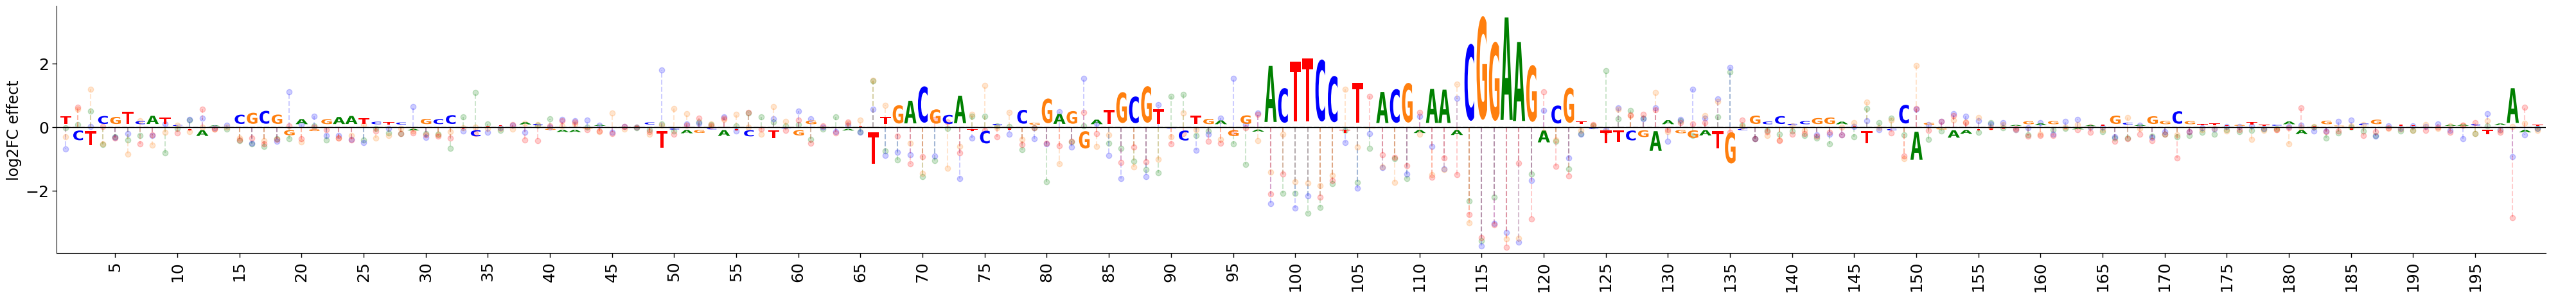

5.07107092059308 4.962026913272554 4.515996817053041


In [ ]:
family_df = satmut_df[satmut_df['project'] == 'boda_saturation'].reset_index(drop=True)

ref_df = family_df[family_df['sat_mut'] == 'm0'].reset_index(drop=True)
alt_df = family_df[family_df['sat_mut'] != 'm0'].reset_index(drop=True)
alt_df = alt_df[alt_df['log2FoldChange'].notnull()].reset_index(drop=True)

parent_id = ref_df['ID'].item()
cell_type = ref_df['celltype'].item()
coda_ref_df = coda_library_df[coda_library_df['ID'] == parent_id]

ref_sequence = coda_ref_df['sequence'].item()
ref_lfc = ref_df['log2FoldChange'].item()
ref_lfcSE = ref_df['lfcSE'].item()

median = np.median(alt_df['log2FoldChange'], keepdims=False)

alphabet_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
alt_array = np.zeros((4, len(ref_sequence)))
lfcSE_array = np.zeros((4, len(ref_sequence)))
for i in range(len(alt_df)):
    single_alt_df = alt_df.iloc[i]
    pos_id = single_alt_df['sat_mut']
    pos_lfc = single_alt_df['log2FoldChange'].item()
    pos_lfcSE = single_alt_df['lfcSE'].item()
    pos_skew = pos_lfc - ref_lfc
    #pos_skew = pos_lfc - median
    pos_id = pos_id.lstrip('m')
    ref_nt, alt_nt = pos_id[0], pos_id[-1]
    pos = int(pos_id.lstrip(ref_nt).rstrip(alt_nt)) - 1
    alt_array[alphabet_dict[alt_nt], pos] = pos_skew
    lfcSE_array[alphabet_dict[alt_nt], pos] = pos_lfcSE

ref_sequence_str = ref_sequence
effect_array     = alt_array
lfcSE_array      = None #lfcSE_array
ref_lfcSE        = None
colors           = ['g', 'b', 'C1', 'r'] #['green','blue','orange','red']
figsize          = (50,5),
marker_alpha     = 0.2
stem_alpha       = 0.2
linestyle        = 'dashed'


markerfmts = [color + 'o' for color in colors]
locs = np.arange(0, effect_array.shape[1])
fig, ax = plt.subplots(figsize=(50,5))

offset = 0.5
for i in range(4):
    heads = np.array(effect_array[i,:], copy=True)
    heads[heads == 0.] = np.nan
    markerline, stemlines, baseline = ax.stem(locs + offset, heads, colors[i], markerfmt=markerfmts[i], basefmt='0.8')
    plt.setp(stemlines, 'linestyle', linestyle)
    plt.setp(stemlines, 'alpha', stem_alpha)
    plt.setp(markerline, 'alpha', marker_alpha)
    #plt.setp(baseline, 'color', 'k')
    plt.setp(baseline, 'alpha', 0.2)
    plt.setp(baseline, 'linestyle', 'dashed')

    #offset += 0.1

plt.margins(x=0.0075)

effect_means = - effect_array.sum(axis=0) / 3.0

if lfcSE_array is not None:
    #lfcSE_means = lfcSE_array.sum(axis=0) / 3.0
    alphas = np.minimum(np.max(lfcSE_array, axis=0), 1.0) ** 2
    shade_color_col='color'
    shade_alpha_col='shade'
# if lfcSE_array is not None and ref_lfcSE is not None:
#     lfcSE_means = lfcSE_array.sum(axis=0) / 3.0
#     alphas = np.minimum(np.maximum(lfcSE_means, ref_lfcSE), 0.90)
#     shade_color_col='color'
#     shade_alpha_col='shade'
else:
    alphas = np.empty(effect_means.shape[0])
    alphas[:] = np.nan
    shade_color_col=None
    shade_alpha_col=None

temp_data = [list(ref_sequence_str), effect_means, alphas]
temp_df = pd.DataFrame(temp_data).transpose()
temp_df.columns = ['letter', 'height', 'shade']

temp_df['color'] = temp_df.apply(lambda x: colors[alphabet_dict[x['letter']]], axis=1)
temp_df['site'] = temp_df.index

y_max = max(effect_array.max(), effect_means.max()) + 0.2
y_min = min(effect_array.min(), effect_means.min()) - 0.2

fig, ax = dmslogo.draw_logo(data=temp_df,
                        x_col='site',
                        letter_col='letter',
                        letter_height_col='height',
                        color_col='color',
                        shade_color_col=shade_color_col,
                        shade_alpha_col=shade_alpha_col,
                        hide_axis=False,
                        fixed_ymax=y_max,
                        fixed_ymin=y_min,
                        ax=ax)

#plt.title('In-vitro', fontsize=32)

plt.xticks(np.arange(4, 199, 5)+0.5, labels=np.arange(4, 199, 5)+1, fontsize=18)
plt.xlabel('')
#ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(True)
#ax.spines['bottom'].set_visible(False)
fig.set_facecolor('white')

plt.ylabel('log2FC effect')
plt.yticks(fontsize=18)
#plt.title(f'{parent_id}   {cell_type.upper()}', fontsize=32)

fig_path = f'/content/drive/MyDrive/figures/CODA_SKNSH_SatMut/' + f'{parent_id}_{cell_type}' + '.pdf'
#plt.savefig(fig_path, format='pdf', bbox_inches='tight', dpi=150, transparent=True)

plt.show()

print(ref_lfc, median, coda_ref_df['SKNSH_signal'].item())

#Call blocks and motifs

In [ ]:
class constants():
    def __init__(self):
        self.STANDARD_NT = ['A','C','G','T']
        self.DNA_COMPLEMENTS = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
constants = constants()

class utils():
    @staticmethod
    def pad_seq_tensor(seq_tensor, pad_len=217, dim=-1):
        assert seq_tensor.shape[dim] <= pad_len
        padded_tensor = torch.zeros((4, pad_len))
        padded_tensor[:, 0:seq_tensor.shape[dim]] = seq_tensor
        return padded_tensor

    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

    @staticmethod
    def reverse_complement_onehot(x, nt_order=constants.STANDARD_NT,
                              complements=constants.DNA_COMPLEMENTS):
        comp_alphabet = [ complements[nt] for nt in nt_order ]
        permutation = [ nt_order.index(nt) for nt in comp_alphabet ]
        return torch.flip(x[..., permutation, :], dims=[-1])

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def tensor_to_pandas(in_tensor, tokens=constants.STANDARD_NT, colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.55, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8, colors=['green','blue','orange','red']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax


def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

def double_pad_seq_tensor(seq_tensor, pad_len=25):
    total_out_len = 2*pad_len + seq_tensor.shape[-1] - 2
    padded_tensor = torch.zeros((4, total_out_len))
    tensor_start = pad_len-1
    tensor_stop = tensor_start + seq_tensor.shape[-1]
    padded_tensor[..., tensor_start:tensor_stop] = seq_tensor
    return padded_tensor

def str2tensor(array_string):
    return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

In [ ]:
def process_raw_motif(raw_motif):
    motif_pwm = torch.Tensor(raw_motif)
    motif_pwm = motif_pwm * 20 / motif_pwm.abs().sum(dim=0).max().item()
    motif_ppm = torch.softmax(motif_pwm, dim=0)
    motif_icm = ppm_to_IC(motif_ppm)
    return motif_ppm, motif_icm

def top_n_matches(motif_icm, pssm_filters, num_motifs, tf_df, n_top_matches, icm_column_dict={0: 'icm', 1: 'icm_rc'}):
    pad_len = pssm_filters.shape[-1] + 1
    padded_icm = double_pad_seq_tensor(motif_icm, pad_len=pad_len)
    scan_scores = F.conv1d(padded_icm.view(1,4,-1), pssm_filters)
    values, indices = scan_scores.max(dim=-1)
    values, indices = values.numpy().flatten(), indices.numpy().flatten()

    flat_padded_icm = padded_icm.numpy().flatten()
    flat_padded_match_icms = []
    for i in range(pssm_filters.shape[0]):
        position = indices[i]
        motif_idx = i % num_motifs
        icm_column = icm_column_dict[i // num_motifs]
        known_motif_icm = torch.Tensor(tf_df.iloc[motif_idx][icm_column])
        padded_match_icm = np.zeros_like(padded_icm)
        padded_match_icm[:, position : position + known_motif_icm.shape[1]] = known_motif_icm
        flat_padded_match_icms.append(padded_match_icm.flatten())

    flat_padded_match_icms = np.stack(flat_padded_match_icms)
    for_pearson_calculation = np.concatenate([flat_padded_match_icms, flat_padded_icm.reshape(1,-1)], axis=0)
    pearsons = np.corrcoef(for_pearson_calculation)[-1][:-1]

    top_n_idxs = np.argsort(-pearsons)[:n_top_matches]
    top_n_pearsons = pearsons[top_n_idxs]
    offsets = [indices[k] - pad_len + 1 for k in top_n_idxs]

    return top_n_idxs, top_n_pearsons, offsets

def best_insert_match(start, stop, effect_array, effect_means, pssm_filters, num_motifs, tf_df, n_top_matches,
                      all_known_motif_icms, all_known_motif_names, return_top_n=False, insert_att=0.3):
    seq_len = effect_means.shape[0]
    window_len = stop - start
    window_effects = effect_means[start:stop]
    window_effect_mean = window_effects.mean()
    window_skews = effect_array[:, start:stop]
    window_directionality = np.sign(window_effect_mean)
    #raw_motif = window_directionality * (window_skews + (window_skews == 0) * window_effects)
    raw_motif = window_directionality * window_skews
    #--- Construct motif
    # motif_pwm = torch.Tensor(raw_motif)
    # motif_pwm = motif_pwm * 5/motif_pwm.max()
    # motif_ppm = torch.softmax(motif_pwm, dim=0)
    # motif_icm = ppm_to_IC(motif_ppm)
    motif_ppm, motif_icm = process_raw_motif(raw_motif)
    #--- Find matches
    top_n_idxs, top_n_pearsons, offsets = top_n_matches(motif_icm, pssm_filters, num_motifs, tf_df, n_top_matches)
    insert_pearsons = []
    pearson_p_values = []
    for local_idx, global_idx in enumerate(top_n_idxs):
        match_icm = all_known_motif_icms[global_idx]
        match_name = all_known_motif_names[global_idx]
        offset = offsets[local_idx]
        original_pearson = top_n_pearsons[local_idx]
        match_start = start + offset
        match_stop = match_start + match_icm.shape[1]
        if match_start < 0:
            match_icm = match_icm[:, -match_start:]
            match_start = 0
        if match_stop > seq_len:
            match_icm = match_icm[:, :seq_len-match_stop]
            match_stop = seq_len
        match_window_effects = effect_means[match_start:match_stop]
        match_window_skews = effect_array[:, match_start:match_stop]
        #match_raw_window_motif = window_directionality * (match_window_skews + (match_window_skews == 0) * match_window_effects)
        match_raw_window_motif = window_directionality * match_window_skews
        # window_motif_pwm = torch.Tensor(match_raw_window_motif)
        # window_motif_pwm = window_motif_pwm * 5/window_motif_pwm.max()
        # window_motif_ppm = torch.softmax(window_motif_pwm, dim=0)
        # window_motif_icm = ppm_to_IC(window_motif_ppm)
        window_motif_ppm, window_motif_icm = process_raw_motif(match_raw_window_motif)
        insert_pearson, pearson_p_value = stats.pearsonr(match_icm.flatten(), window_motif_icm.numpy().flatten())
        insert_pearsons.append(insert_pearson)
        pearson_p_values.append(pearson_p_value)

    deciding_pearsons = insert_att * np.array(insert_pearsons) + (1 - insert_att) * top_n_pearsons
    best_insert_match_idx = deciding_pearsons.argmax()
    best_insert_icm = all_known_motif_icms[top_n_idxs[best_insert_match_idx]]
    best_insert_name = all_known_motif_names[top_n_idxs[best_insert_match_idx]]
    best_insert_pearson = insert_pearsons[best_insert_match_idx]
    best_insert_p_value = pearson_p_values[best_insert_match_idx]
    best_insert_offset = offsets[best_insert_match_idx]
    best_insert_start = max(0, start + best_insert_offset)
    best_insert_stop = min(200, best_insert_start + best_insert_icm.shape[1])
    block_pearson = np.round(top_n_pearsons[best_insert_match_idx], 2)

    match_dict = {
                'match_name': best_insert_name,
                'match_icm': best_insert_icm,
                'match_start': best_insert_start,
                'match_stop': best_insert_stop,
                'window_match_pearson': best_insert_pearson,
                'pearson_p_value': best_insert_p_value,
                'block_match_pearson': block_pearson,
                }

    if return_top_n:
        top_n_info = [top_n_idxs, top_n_pearsons, offsets, insert_pearsons, pearson_p_values]
        return match_dict, top_n_info
    else:
        return match_dict

def plot_box(match_dict, box_sign, effect_array, effect_means, box_params, ax):
    best_insert_start = match_dict['match_start']
    best_insert_stop = match_dict['match_stop']
    best_insert_name = match_dict['match_name']
    best_insert_pearson = match_dict['window_match_pearson']
    best_insert_window_effects = effect_means[best_insert_start:best_insert_stop]
    best_insert_window_skews = effect_array[:, best_insert_start:best_insert_stop]

    linestyles    = box_params['linestyles']
    color         = box_params['color']
    box_linewidth = box_params['box_linewidth']
    box_alpha     = box_params['box_alpha']
    text_fontsize = box_params['text_fontsize']
    box_pad       = box_params['box_pad']

    if box_sign == '+':
        window_y_min = min(0, best_insert_window_effects.min()) - 0.5 * box_pad
        window_y_max = max(best_insert_window_skews.max(), best_insert_window_effects.max()) + box_pad
    elif box_sign == "-":
        window_y_min = min(best_insert_window_skews.min(), best_insert_window_effects.min()) - box_pad
        window_y_max = max(0, best_insert_window_effects.max()) + 0.5 * box_pad

    ax.vlines(best_insert_start, window_y_min, window_y_max, linestyles=linestyles, colors=color, linewidth=box_linewidth, alpha=box_alpha)
    ax.vlines(best_insert_stop, window_y_min, window_y_max, linestyles=linestyles, colors=color, linewidth=box_linewidth, alpha=box_alpha)
    ax.hlines(window_y_min, best_insert_start, best_insert_stop, linestyles=linestyles, colors=color, linewidth=box_linewidth, alpha=box_alpha)
    ax.hlines(window_y_max, best_insert_start, best_insert_stop, linestyles=linestyles, colors=color, linewidth=box_linewidth, alpha=box_alpha)

    print_pearson = np.round(best_insert_pearson, 2)
    plt.text(best_insert_start+0.1, window_y_max+0.3, f'{best_insert_name}\n(r={print_pearson})', fontsize=text_fontsize,
             rotation=90)

    return best_insert_start, best_insert_stop, ax

In [ ]:
#file_path = '/content/drive/MyDrive/data/tf_motifs/HOCOMOCO_and_JASPAR_processed_TF_info.txt'
#file_path = '/content/drive/MyDrive/data/tf_motifs/HOCOMOCO_and_JASPAR_processed_TF_info_noPseudo.txt'
file_path = "/content/drive/MyDrive/data/tf_motifs/H12CORE_and_JASPAR_processed_TF_info_noPseudo.txt"

tf_df = pd.read_csv(file_path, sep=' ', low_memory=False)
tf_df = tf_df[tf_df['short_name'].str.isupper()].reset_index(drop=True) #Keep only human TFs
jaspar_rows = tf_df['database'] == 'JASPAR'
tf_df.loc[jaspar_rows, 'name'] = tf_df[jaspar_rows][['short_name', 'name']].agg('_'.join, axis=1).tolist() #Improve JASPAR names

df_array_columns = ['pfm', 'pwm', 'pwm_rc', 'pssm', 'pssm_rc', 'icm', 'icm_rc', 'padded_pssm', 'padded_pssm_rc']
for df_array_column in df_array_columns:
    tf_df[df_array_column] = tf_df.apply(lambda x: string_to_numpy(x[df_array_column]), axis=1)

motif_list = tf_df['name'].tolist()
num_motifs = len(tf_df)

PSSMs = torch.Tensor(np.stack(tf_df['padded_pssm'].tolist(), axis=0))
PSSMs_rc = torch.Tensor(np.stack(tf_df['padded_pssm_rc'].tolist(), axis=0))
pssm_filters = torch.cat([PSSMs, PSSMs_rc])

all_known_motif_icms = tf_df['icm'].tolist() + tf_df['icm_rc'].tolist()
all_known_motif_names = [name + ' +' for name in tf_df['name'].tolist()] + [name + ' -' for name in tf_df['name'].tolist()]

icm_column_dict = {0: 'icm', 1: 'icm_rc'}
pad_len = pssm_filters.shape[-1] + 1

left gap 1


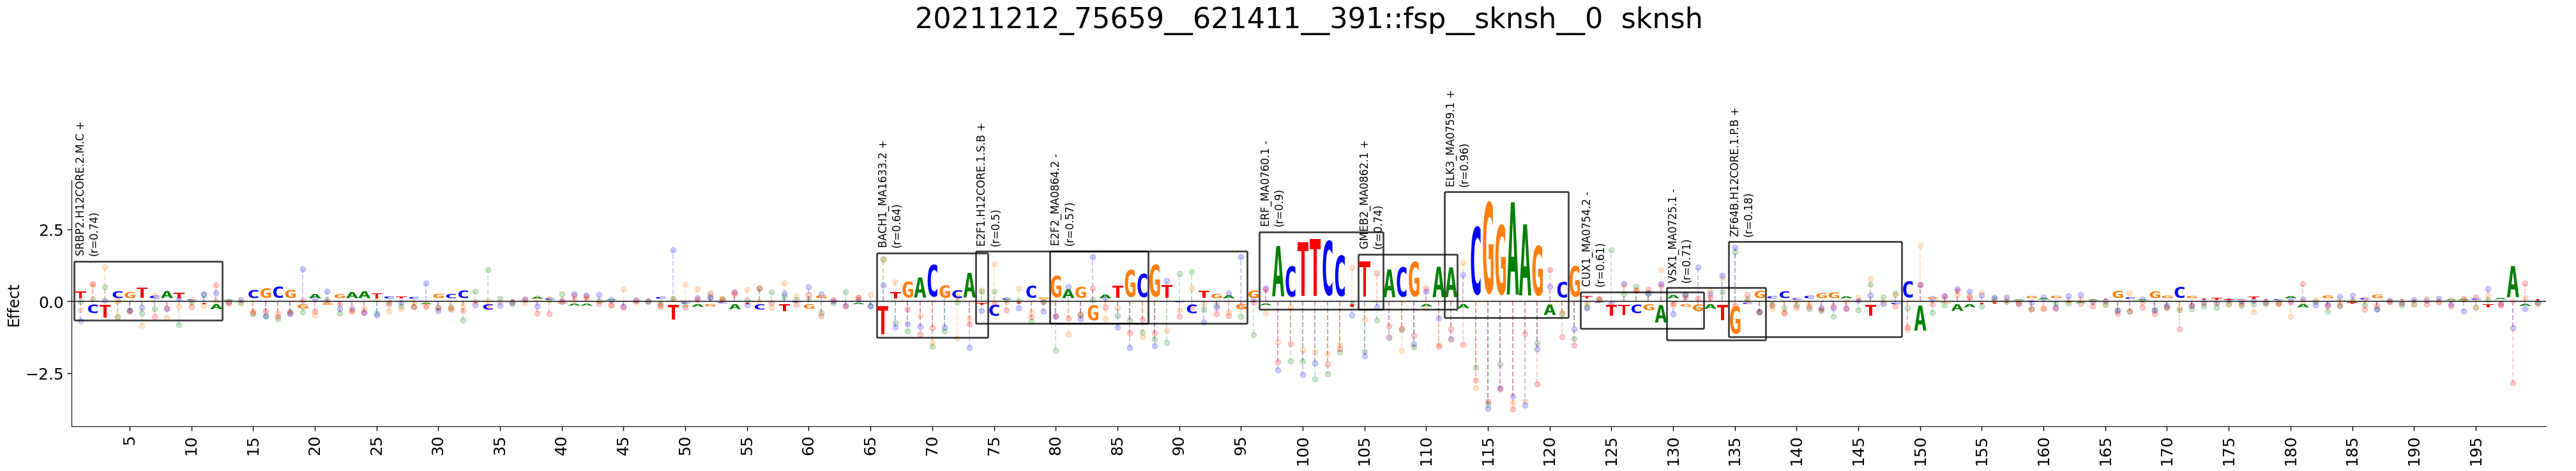

In [ ]:
from scipy.ndimage import gaussian_filter1d

#--- Number of best matches to the block to asses match potentially beyond block
n_top_matches = 10

#--- Gaussian block params
min_mean  = 0.15
min_len   = 5
sigma     = 1.15
threshold = 0.2

#--- Sequence logo and skew plot params
colors       = ['g', 'b', 'C1', 'r'] #['green','blue','orange','red']
figsize      = (50,5)
marker_alpha = 0.2
stem_alpha   = 0.2
linestyle    = 'dashed'

#--- Block plot params
box_params = {'linestyles': 'solid', 'color': 'black', 'box_linewidth': 2,
                  'box_alpha': 0.75, 'text_fontsize': 12, 'box_pad': 0.2}

motifs_per_sequence = {}
#--- Get SatMut data
family_df = satmut_df[satmut_df['project'] == 'boda_saturation'].reset_index(drop=True)

ref_df = family_df[family_df['sat_mut'] == 'm0'].reset_index(drop=True)
alt_df = family_df[family_df['sat_mut'] != 'm0'].reset_index(drop=True)
alt_df = alt_df[alt_df['log2FoldChange'].notnull()].reset_index(drop=True)

parent_id = ref_df['ID'].item()
cell_type = ref_df['celltype'].item()
coda_ref_df = coda_library_df[coda_library_df['ID'] == parent_id]

ref_sequence = coda_ref_df['sequence'].item()
ref_lfc = ref_df['log2FoldChange'].item()
ref_lfcSE = ref_df['lfcSE'].item()

median = np.median(alt_df['log2FoldChange'], keepdims=False)

alphabet_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
alt_array = np.zeros((4, len(ref_sequence)))
lfcSE_array = np.zeros((4, len(ref_sequence)))
for i in range(len(alt_df)):
    single_alt_df = alt_df.iloc[i]
    pos_id = single_alt_df['sat_mut']
    pos_lfc = single_alt_df['log2FoldChange'].item()
    pos_lfcSE = single_alt_df['lfcSE'].item()
    pos_skew = pos_lfc - ref_lfc
    #pos_skew = pos_lfc - median
    pos_id = pos_id.lstrip('m')
    ref_nt, alt_nt = pos_id[0], pos_id[-1]
    pos = int(pos_id.lstrip(ref_nt).rstrip(alt_nt)) - 1
    alt_array[alphabet_dict[alt_nt], pos] = pos_skew
    lfcSE_array[alphabet_dict[alt_nt], pos] = pos_lfcSE

# hmm_family = hmm_block_df[(hmm_block_df['sat_ref'] == parent_id) & (hmm_block_df['cell_type'] == cell_type.upper())]
# hmm_family = hmm_family[hmm_family['oligomut'] != 'm0']

# ref_sequence = fasta_dict[f'{parent_id}:m0']

# positions = (hmm_family['mut_pos'] - 1).tolist()
# tokens = hmm_family['mut_base'].tolist()
# skews = hmm_family['post_log2Skew'].tolist()

# alphabet_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
# alt_array = np.zeros((4, len(ref_sequence)))
# for i, position in enumerate(positions):
#     token_idx = alphabet_dict[tokens[i]]
#     alt_array[token_idx, position] = skews[i]
#----

ref_sequence_str = ref_sequence
effect_array     = alt_array

effect_means = - effect_array.sum(axis=0) / 3.0

markerfmts = [color + 'o' for color in colors]
locs = np.arange(0, effect_array.shape[1])
fig, ax = plt.subplots(figsize=figsize)
offset = 0.5
for i in range(4):
    heads = np.array(effect_array[i,:], copy=True)
    heads[heads == 0.] = np.nan
    markerline, stemlines, baseline = ax.stem(locs + offset, heads, colors[i], markerfmt=markerfmts[i], basefmt='0.8')
    plt.setp(stemlines, 'linestyle', linestyle)
    plt.setp(stemlines, 'alpha', stem_alpha)
    plt.setp(markerline, 'alpha', marker_alpha)
    #plt.setp(baseline, 'color', 'k')
    plt.setp(baseline, 'alpha', 0.2)
    plt.setp(baseline, 'linestyle', 'dashed')
    #offset += 0.1
plt.margins(x=0.0075)

#--- Plot logo
temp_data = [list(ref_sequence_str), effect_means]
temp_df = pd.DataFrame(temp_data).transpose()
temp_df.columns = ['letter', 'height']

temp_df['color'] = temp_df.apply(lambda x: colors[alphabet_dict[x['letter']]], axis=1)
temp_df['site'] = temp_df.index

min_limit = 1
y_max = max(min_limit, max(effect_array.max(), effect_means.max()) + 0.1) + 0.5
y_min = min(-min_limit, min(effect_array.min(), effect_means.min()) - 0.1) - 0.5

fig, ax = dmslogo.draw_logo(data=temp_df,
                        x_col='site',
                        letter_col='letter',
                        letter_height_col='height',
                        color_col='color',
                        hide_axis=False,
                        fixed_ymax=y_max,
                        fixed_ymin=y_min,
                        ax=ax)

#--- MOTIF calls
ysmoothed = gaussian_filter1d(effect_means, sigma=sigma)
motif_calls = []
seq_len = effect_means.shape[0]

#---Positive chunks
box_sign = '+'
differences = ysmoothed - threshold
cross_idxs = np.where((np.sign(differences * np.roll(differences, 1)) < 1 ))[0]
if len(cross_idxs) >0:
    if cross_idxs[0] != 0:
        cross_idxs = np.concatenate([np.zeros(1), cross_idxs, np.array([differences.shape[0]])]).astype(int)
    start_stops = [(cross_idxs[i-1], cross_idxs[i]) for i in range(1, len(cross_idxs))]
    if len(start_stops) > 0:
        for start, stop in start_stops:
            window_len = stop - start
            window_effects = effect_means[start:stop]
            window_effect_mean = window_effects.mean()
            window_effect_median = np.median(window_effects) #use median?
            if window_effect_mean >= min_mean and window_len >= min_len:
                window_skews = effect_array[:, start:stop] #[:, max(0, start - 1): min(200, stop + 1)]#
                window_directionality = np.sign(window_effect_mean)
                raw_motif = window_directionality * window_skews
                #--- Construct motif
                # motif_pwm = torch.Tensor(raw_motif)
                # motif_pwm = motif_pwm * 20 / motif_pwm.sum(dim=0).abs().max().item() #motif_pwm * 1.1 / motif_pwm.max()
                # motif_ppm = torch.softmax(motif_pwm, dim=0)
                # motif_icm = ppm_to_IC(motif_ppm)
                motif_ppm, motif_icm = process_raw_motif(raw_motif)
                #--- Find matches
                motif_matches = []
                match_dict, top_n_info = best_insert_match(start, stop, effect_array, effect_means,
                                                            pssm_filters, num_motifs, tf_df, n_top_matches,
                                                            all_known_motif_icms, all_known_motif_names,
                                                            return_top_n=True)
                motif_matches.append(match_dict)
                best_insert_start, best_insert_stop, ax = plot_box(match_dict, box_sign,
                                                                effect_array, effect_means, box_params, ax=ax)
                #--- Handle missing left sides
                if best_insert_start - start >= 5:
                    new_window_stop = best_insert_start
                    match_dict = best_insert_match(start, new_window_stop, effect_array, effect_means,
                                                            pssm_filters, num_motifs, tf_df, n_top_matches,
                                                            all_known_motif_icms, all_known_motif_names)
                    motif_matches.append(match_dict)
                    new_insert_start, new_insert_stop, ax = plot_box(match_dict, box_sign,
                                                                    effect_array, effect_means, box_params, ax=ax)
                    if best_insert_start - new_insert_stop >= 5:  #if there is a gap between 1st and 2nd match
                        new_window_start = new_insert_stop
                        match_dict = best_insert_match(new_window_start, new_window_stop, effect_array, effect_means,
                                                            pssm_filters, num_motifs, tf_df, n_top_matches,
                                                            all_known_motif_icms, all_known_motif_names)
                        motif_matches.append(match_dict)
                        new_insert_start, new_insert_stop, ax = plot_box(match_dict, box_sign,
                                                                        effect_array, effect_means, box_params, ax=ax)
                        print('left gap 1')
                    elif new_insert_start - start >= 5:         #if there is a gap to the left of 2nd match
                        new_window_stop = new_window_start
                        match_dict = best_insert_match(start, new_window_stop, effect_array, effect_means,
                                                            pssm_filters, num_motifs, tf_df, n_top_matches,
                                                            all_known_motif_icms, all_known_motif_names)
                        motif_matches.append(match_dict)
                        new_insert_start, new_insert_stop, ax = plot_box(match_dict, box_sign,
                                                                        effect_array, effect_means, box_params, ax=ax)
                        print('left gap 2')
                #--- Handle missing right sides
                if stop - best_insert_stop >= 5:
                    new_window_start = best_insert_stop
                    match_dict = best_insert_match(new_window_start, stop, effect_array, effect_means,
                                                            pssm_filters, num_motifs, tf_df, n_top_matches,
                                                            all_known_motif_icms, all_known_motif_names)
                    motif_matches.append(match_dict)
                    new_insert_start, new_insert_stop, ax = plot_box(match_dict, box_sign,
                                                                    effect_array, effect_means, box_params, ax=ax)
                    if new_insert_start - new_window_start >= 5:  #if there is a gap between 1st and 2nd match
                        new_window_stop = new_insert_start
                        match_dict = best_insert_match(new_window_start, new_window_stop, effect_array, effect_means,
                                                            pssm_filters, num_motifs, tf_df, n_top_matches,
                                                            all_known_motif_icms, all_known_motif_names)
                        motif_matches.append(match_dict)
                        new_insert_start, new_insert_stop, ax = plot_box(match_dict, box_sign,
                                                                        effect_array, effect_means, box_params, ax=ax)
                        print('right gap 1')
                    elif stop - new_insert_stop >= 5:
                        new_window_start = new_insert_stop     #if there is a gap to the right of 2nd match
                        match_dict = best_insert_match(new_window_start, stop, effect_array, effect_means,
                                                            pssm_filters, num_motifs, tf_df, n_top_matches,
                                                            all_known_motif_icms, all_known_motif_names)
                        motif_matches.append(match_dict)
                        new_insert_start, new_insert_stop, ax = plot_box(match_dict, box_sign,
                                                                        effect_array, effect_means, box_params, ax=ax)
                        print('right gap 2')

                #--- Save constructed motif and match
                complete_match_dict = {'start': start,
                                'stop': stop,
                                'effect_mean': window_effect_mean,
                                'direction': window_directionality,
                                'raw_motif': raw_motif,
                                'motif_icm': motif_icm,
                                'top_n_info': top_n_info,
                                'motif_matches': motif_matches
                                }
                motif_calls.append(complete_match_dict)

#---Negative chunks
box_sign = '-'
differences = ysmoothed + threshold
cross_idxs = np.where((np.sign(differences * np.roll(differences, 1)) < 1 ))[0]
if len(cross_idxs) >0:
    if cross_idxs[0] != 0:
        cross_idxs = np.concatenate([np.zeros(1), cross_idxs, np.array([effect_means.shape[0]])]).astype(int)
    start_stops = [(cross_idxs[i-1], cross_idxs[i]) for i in range(1, len(cross_idxs))]
    for start, stop in start_stops:
        window_len = stop - start
        window_effects = effect_means[start:stop]
        window_effect_mean = window_effects.mean()
        window_effect_median = np.median(window_effects) #use median?
        if window_effect_mean <= -min_mean and window_len >= min_len:
            window_skews = effect_array[:, start:stop] #[:, max(0, start - 1): min(200, stop + 1)]#
            window_directionality = np.sign(window_effect_mean)
            raw_motif = window_directionality * window_skews
            #--- Construct motif
            # motif_pwm = torch.Tensor(raw_motif)
            # motif_pwm = motif_pwm * 20 / motif_pwm.sum(dim=0).abs().max().item() #motif_pwm * 1.1 / motif_pwm.max()
            # motif_ppm = torch.softmax(motif_pwm, dim=0)
            # motif_icm = ppm_to_IC(motif_ppm)
            motif_ppm, motif_icm = process_raw_motif(raw_motif)
            #--- Find matches
            motif_matches = []
            match_dict, top_n_info = best_insert_match(start, stop, effect_array, effect_means,
                                                        pssm_filters, num_motifs, tf_df, n_top_matches,
                                                        all_known_motif_icms, all_known_motif_names,
                                                        return_top_n=True)
            motif_matches.append(match_dict)
            best_insert_start, best_insert_stop, ax = plot_box(match_dict, box_sign,
                                                            effect_array, effect_means, box_params, ax=ax)
            #--- Handle missing left sides
            if best_insert_start - start >= 5:
                new_window_stop = best_insert_start
                match_dict = best_insert_match(start, new_window_stop, effect_array, effect_means,
                                                            pssm_filters, num_motifs, tf_df, n_top_matches,
                                                            all_known_motif_icms, all_known_motif_names)
                motif_matches.append(match_dict)
                new_insert_start, new_insert_stop, ax = plot_box(match_dict, box_sign,
                                                            effect_array, effect_means, box_params, ax=ax)
                if best_insert_start - new_insert_stop >= 5:  #if there is a gap between 1st and 2nd match
                    new_window_start = new_insert_stop
                    match_dict = best_insert_match(new_window_start, new_window_stop, effect_array, effect_means,
                                                            pssm_filters, num_motifs, tf_df, n_top_matches,
                                                            all_known_motif_icms, all_known_motif_names)
                    motif_matches.append(match_dict)
                    new_insert_start, new_insert_stop, ax = plot_box(match_dict, box_sign,
                                                            effect_array, effect_means, box_params, ax=ax)
                elif new_insert_start - start >= 5:         #if there is a gap to the left of 2nd match
                    new_window_stop = new_window_start
                    match_dict = best_insert_match(start, new_window_stop, effect_array, effect_means,
                                                            pssm_filters, num_motifs, tf_df, n_top_matches,
                                                            all_known_motif_icms, all_known_motif_names)
                    motif_matches.append(match_dict)
                    new_insert_start, new_insert_stop, ax = plot_box(match_dict, box_sign,
                                                            effect_array, effect_means, box_params, ax=ax)
            #--- Handle missing right sides
            if stop - best_insert_stop >= 5:
                new_window_start = best_insert_stop
                match_dict = best_insert_match(new_window_start, stop, effect_array, effect_means,
                                                            pssm_filters, num_motifs, tf_df, n_top_matches,
                                                            all_known_motif_icms, all_known_motif_names)
                motif_matches.append(match_dict)
                new_insert_start, new_insert_stop, ax = plot_box(match_dict, box_sign,
                                                            effect_array, effect_means, box_params, ax=ax)
                if new_insert_start - new_window_start >= 5:  #if there is a gap between 1st and 2nd match
                    new_window_stop = new_insert_start
                    match_dict = best_insert_match(new_window_start, new_window_stop, effect_array, effect_means,
                                                            pssm_filters, num_motifs, tf_df, n_top_matches,
                                                            all_known_motif_icms, all_known_motif_names)
                    motif_matches.append(match_dict)
                    new_insert_start, new_insert_stop, ax = plot_box(match_dict, box_sign,
                                                            effect_array, effect_means, box_params, ax=ax)
                elif stop - new_insert_stop >= 5:           #if there is a gap to the right of 2nd match
                    match_dict = best_insert_match(new_window_start, new_window_stop, effect_array, effect_means,
                                                            pssm_filters, num_motifs, tf_df, n_top_matches,
                                                            all_known_motif_icms, all_known_motif_names)
                    motif_matches.append(match_dict)
                    new_insert_start, new_insert_stop, ax = plot_box(match_dict, box_sign,
                                                            effect_array, effect_means, box_params, ax=ax)
            #--- Save constructed motif and match
            match_dict = {'start': start,
                        'stop': stop,
                        'effect_mean': window_effect_mean,
                        'direction': window_directionality,
                        'raw_motif': raw_motif,
                        'motif_icm': motif_icm,
                        'top_n_info': top_n_info,
                        'motif_matches': motif_matches
                        }
            motif_calls.append(match_dict)

if len(motif_calls) > 0:
    motifs_per_sequence[parent_id] = motif_calls
else:
    motifs_per_sequence[parent_id] = {}

plt.xticks(np.arange(4, 199, 5)+0.5, labels=np.arange(4, 199, 5)+1, fontsize=18)
plt.xlabel('')
#ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(True)
#ax.spines['bottom'].set_visible(False)
fig.set_facecolor('white')
#plt.ylim(-5,6)
plt.ylabel('Effect')
plt.yticks(fontsize=18)
plt.margins(y=1)
plt.title(f'{parent_id}  {cell_type}', fontsize=32, y=1.6)
#fig_path = f'/content/drive/MyDrive/figures/OL50_saturation_mutagenesis/logos_with_TF_matches_posterior_v8/' + f'{parent_id}_{cell_type}' + '.pdf'
#plt.savefig(fig_path, format='pdf', bbox_inches='tight', dpi=150, transparent=True)
plt.show()

In [ ]:
for motif_call in motif_calls:
    start, stop = motif_call['start'], motif_call['stop']
    print(f'Block start-stop: {start}-{stop}')
    top_n_data = motif_call['top_n_info']
    tf_idxs, tf_block_pearsons, tf_insert_pearsons= top_n_data[0], top_n_data[1], top_n_data[3]
    for tf_idx, tf_block_pearson, tf_insert_pearson in zip(tf_idxs, tf_block_pearsons, tf_insert_pearsons):
        tf_local_idx = tf_idx % num_motifs
        rc_flag = tf_idx // num_motifs
        tf_name = tf_df.iloc[tf_local_idx]['name']
        print(f'Match name: {tf_name} | Block Pearson: {np.round(tf_block_pearson, 2)} | Insert Pearson: {np.round(tf_insert_pearson, 2)}')
    print()

Block start-stop: 4-9
Match name: SRBP2.H12CORE.2.M.C | Block Pearson: 0.89 | Insert Pearson: 0.74
Match name: SRBP2.H12CORE.0.S.B | Block Pearson: 0.86 | Insert Pearson: 0.8
Match name: SRBP1.H12CORE.0.P.B | Block Pearson: 0.85 | Insert Pearson: 0.69
Match name: SRBP1.H12CORE.1.S.C | Block Pearson: 0.84 | Insert Pearson: 0.75
Match name: ATF3.H12CORE.1.P.B | Block Pearson: 0.84 | Insert Pearson: 0.67
Match name: PAX3.H12CORE.1.SM.B | Block Pearson: 0.84 | Insert Pearson: 0.65
Match name: ARNT2.H12CORE.0.P.B | Block Pearson: 0.84 | Insert Pearson: 0.54
Match name: MAFG::NFE2L1_MA0089.1 | Block Pearson: 0.83 | Insert Pearson: 0.75
Match name: MITF.H12CORE.0.P.B | Block Pearson: 0.81 | Insert Pearson: 0.57
Match name: ATF3.H12CORE.1.P.B | Block Pearson: 0.81 | Insert Pearson: 0.66

Block start-stop: 67-73
Match name: BATF.H12CORE.1.P.B | Block Pearson: 0.84 | Insert Pearson: 0.55
Match name: BATF3.H12CORE.1.P.B | Block Pearson: 0.82 | Insert Pearson: 0.55
Match name: BACH1_MA1633.2 | Blo